<a href="https://colab.research.google.com/github/suzy97/HYU_AI2/blob/main/SujiBaek_ICT4010_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os # 파이썬을 이용해 파일을 복사하거나 디렉터리를 생성하고 특정 디렉터리 내의 파일 목록을 구하고자 할 때 사용
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision # torchvision package : 컴퓨터 비전을 위한 유명 데이터셋, 모델 아키텍처, 이미지 변형등을 포함
import torch.nn as nn # nn : neural netwroks (define class) attribute를 활용해 state를 저장하고 활용
import torch.optim as optim # 최적화 알고리즘
import torch.nn.functional as F # (define function) 인스턴스화 시킬 필요없이 사용 가능
from PIL import Image
from torchvision import transforms, datasets # transforms : 데이터를 조작하고 학습에 적합하게 만듦.
from torch.utils.data import Dataset, DataLoader
# dataset : 샘플과 정답(label)을 저장
# DataLoader : Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다.

In [30]:
epochs = 10 # 훈련 반복수
batch_size = 512 # 배치 크기

device = ("cuda" if torch.cuda.is_available() else "cpu") # device 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # 총 10개의 클래스

print(torch.__version__)
print(device)

# 결과
# 2.0.1+cu118
# cuda


2.0.1+cu118
cuda


In [31]:
#데이터 셋 준비
transform = transforms.Compose([
    transforms.Resize(227), # Compose : transforms 리스트 구성
    # 227x227 : input image(in alexnet) but fashionMNIST's input image : 28x28
    transforms.ToTensor()]) # ToTensor : PIL image or numpy.ndarray를 tensor로 바꿈

training_data = datasets.FashionMNIST(
    root="data", # data가 저장될 경로(path)
    train=True, # training dataset
    download=True, # 인터넷으로부터 데이터 다운
    transform=transform # feature 및 label 변환(transformation) 지정
)

validation_data = datasets.FashionMNIST(
    root="data",
    train=False, # test dataset
    download=True,
    transform=transform
)

In [59]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=227, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [60]:
validation_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=227, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [5]:
#Data Loader
# (class) DataLoader(dataset, batch_size, shuffle, ...)
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

Shirt


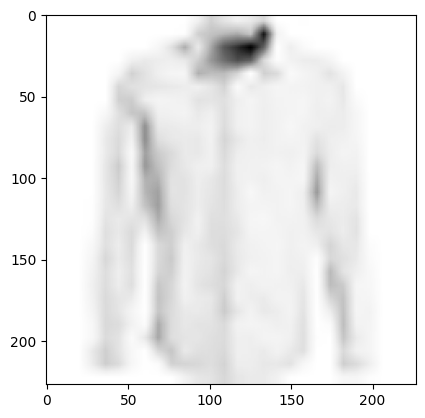

In [67]:
#Image Check
# helper function to show an image
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")

# get some random training images
#dataiter = iter(training_loader) # iter(호출가능한객체, 반복을끝낼값)
#images, labels = dataiter.next() # next() : 반복할 수 있을 때는 해당 값을 출력하고, 반복이 끝났을 때는 기본값을 출력


# create grid of images
img_grid = torchvision.utils.make_grid(images[0]) # make_grid : 이미지의 그리드 생성

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

In [115]:
class AlexNet_Fashion_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out


In [116]:
model = AlexNet_Fashion_MNIST().to(device) # to()로 모델에 gpu 사용
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters()) # model(신경망) 파라미터를 optimizer에 전달해줄 때 nn.Module의 parameters() 메소드를 사용


In [117]:
from torchsummary import summary as summary_

summary_(model, (1,227,227))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          11,712
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
           Linear-14                 [-

In [124]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # enumberate() : 인덱스와 원소로 이루어진 튜플(tuple)을 만들어줌
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 항상 backpropagation 하기전에 미분(gradient)을 zero로 만들어주고 시작해야 한다.
        output = model(data)
        loss = criterion(output, target) # criterion = loss_fn
        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves
        optimizer.step() # step() : 파라미터를 업데이트함
        if (batch_idx) % 100 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


In [125]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        #print test_loss & accuracy
        test_loss /= len(test_loader.dataset)  # -> mean
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)


In [126]:
for epoch in range(1, epochs+1):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, validation_loader)


Train Epoch:1 [0/60000 (0%)]	Loss: 0.239006
Train Epoch:1 [6400/60000 (11%)]	Loss: 0.174198
Train Epoch:1 [12800/60000 (21%)]	Loss: 0.243132
Train Epoch:1 [19200/60000 (32%)]	Loss: 0.222775
Train Epoch:1 [25600/60000 (43%)]	Loss: 0.317593
Train Epoch:1 [32000/60000 (53%)]	Loss: 0.254431
Train Epoch:1 [38400/60000 (64%)]	Loss: 0.431509
Train Epoch:1 [44800/60000 (75%)]	Loss: 0.457853
Train Epoch:1 [51200/60000 (85%)]	Loss: 0.178561
Train Epoch:1 [57600/60000 (96%)]	Loss: 0.464364

Test set: Average loss: 0.2975, Accuracy: 8938/10000 (89%)

Train Epoch:2 [0/60000 (0%)]	Loss: 0.245322
Train Epoch:2 [6400/60000 (11%)]	Loss: 0.292069
Train Epoch:2 [12800/60000 (21%)]	Loss: 0.289268
Train Epoch:2 [19200/60000 (32%)]	Loss: 0.194659
Train Epoch:2 [25600/60000 (43%)]	Loss: 0.186853
Train Epoch:2 [32000/60000 (53%)]	Loss: 0.402479
Train Epoch:2 [38400/60000 (64%)]	Loss: 0.148045
Train Epoch:2 [44800/60000 (75%)]	Loss: 0.675111
Train Epoch:2 [51200/60000 (85%)]	Loss: 0.325495
Train Epoch:2 [57600